# Machine Learning

--- 
## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

sb.set()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

--- 
## Load Data

In [3]:
path = '../data/'
X = pd.read_csv(path+'predictors.csv')
y = pd.read_csv(path+'response.csv')

In [4]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.505892,1.054756,-1.362277,-0.644525,-0.142325,-0.434038,-0.284919,0.817412,1.414449,-0.616944,-1.005353
1,-0.231910,2.125547,-1.362277,0.916965,1.328430,1.199528,1.025208,0.185197,-0.950323,0.458296,-0.601346
2,-0.231910,1.411686,-1.142510,0.247755,0.927315,0.032695,0.509097,0.311640,-0.492625,0.189486,-0.601346
3,2.096930,-1.443756,1.714462,-0.644525,-0.209177,0.266062,0.747302,0.943855,-1.255455,-0.437737,-0.601346
4,-0.505892,0.816803,-1.362277,-0.867595,-0.209177,-0.200672,-0.046714,0.817412,1.414449,-0.616944,-1.005353


In [5]:
y.head()

,quality
0,0
1,0
2,0
3,0
4,0


In [6]:
# m samples, n features
m, n = X.shape
print(m, n)

985 11


In [7]:
# list of variable names for easier iterations
variables = list(X.columns.values)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

--- 
## Decision Tree

### Build Model

In [11]:
from sklearn.tree import DecisionTreeClassifier

# use a smaller dataset to find optimal max_depth
X_train_try, X_test_try, y_train_try, y_test_try = train_test_split(X_train.iloc[0:400][:], y_train[0:400][:], train_size=0.7)
for depth in range(2, 10):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(X_train_try, y_train_try)
    print(f"For depth {depth}, train accuracy {model.score(X_train_try, y_train_try):.4f}, test accuracy {model.score(X_test_try, y_test_try):.4f}.")

For depth 2, train accuracy 0.9107, test accuracy 0.8500.
For depth 3, train accuracy 0.9214, test accuracy 0.8500.
For depth 4, train accuracy 0.9357, test accuracy 0.8583.
For depth 5, train accuracy 0.9679, test accuracy 0.8167.
For depth 6, train accuracy 0.9893, test accuracy 0.8083.
For depth 7, train accuracy 1.0000, test accuracy 0.8083.
For depth 8, train accuracy 1.0000, test accuracy 0.8167.
For depth 9, train accuracy 1.0000, test accuracy 0.8167.


Max Depth 4 has a better balance between training and testing accuracy.

In [12]:
# choose 4 as max_depth
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

### Plot Decision Tree

[Text(0.3958333333333333, 0.9, 'alcohol <= 0.762\ngini = 0.223\nsamples = 788\nvalue = [687, 101]\nclass = 0'),
 Text(0.125, 0.7, 'pH <= -2.285\ngini = 0.107\nsamples = 597\nvalue = [563, 34]\nclass = 0'),
 Text(0.08333333333333333, 0.5, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = 1'),
 Text(0.16666666666666666, 0.5, 'volatile acidity <= -0.819\ngini = 0.099\nsamples = 594\nvalue = [563, 31]\nclass = 0'),
 Text(0.08333333333333333, 0.3, 'chlorides <= -1.145\ngini = 0.292\nsamples = 107\nvalue = [88, 19]\nclass = 0'),
 Text(0.041666666666666664, 0.1, 'gini = 0.492\nsamples = 16\nvalue = [7, 9]\nclass = 1'),
 Text(0.125, 0.1, 'gini = 0.196\nsamples = 91\nvalue = [81, 10]\nclass = 0'),
 Text(0.25, 0.3, 'residual sugar <= -2.094\ngini = 0.048\nsamples = 487\nvalue = [475, 12]\nclass = 0'),
 Text(0.20833333333333334, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = 1'),
 Text(0.2916666666666667, 0.1, 'gini = 0.044\nsamples = 486\nvalue = [475, 11]\nclass = 0'),
 Text(0.666666666

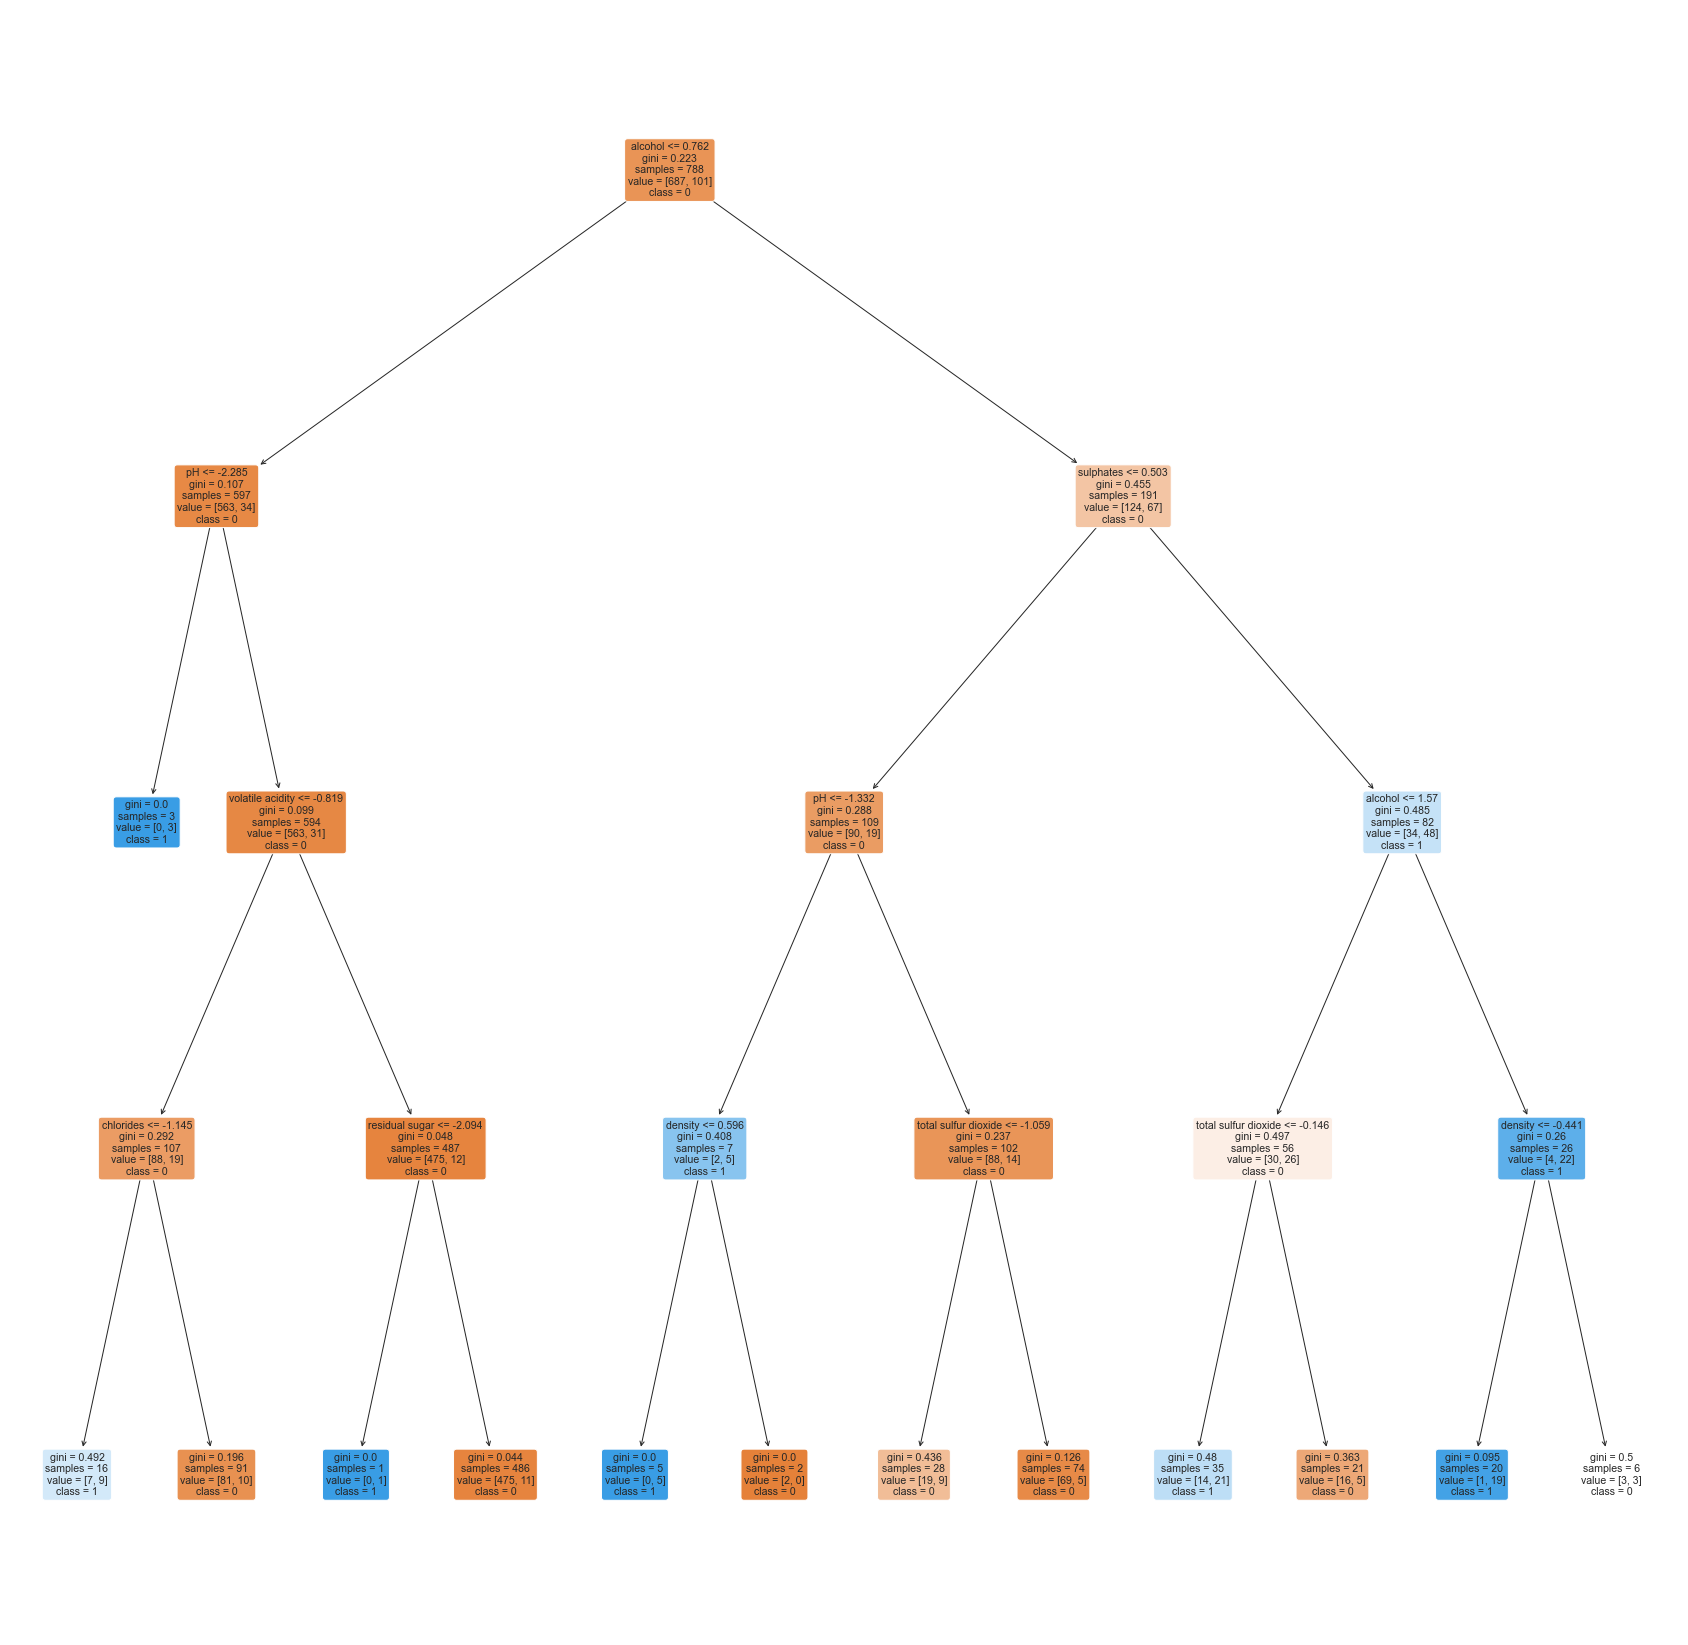

In [13]:
from sklearn.tree import plot_tree

classes = ['0', '1']
f = plt.figure(figsize=(30, 30))
plot_tree(decision_tree=model, 
            filled=True,
            rounded=True,
            feature_names=X_train.columns,
            class_names=classes)

### Evaluate Model

In [14]:
# overall accuracy
print(f"For training data, accuracy={model.score(X_train, y_train)}.")
print(f"For testing data, accuracy={model.score(X_test, y_test)}.")


For training data, accuracy=0.9175126903553299.
For testing data, accuracy=0.8629441624365483.


In [15]:
from sklearn.metrics import confusion_matrix

def evaluate(y_pre, y_act, plotConfusionMatrix=True):
    cm = confusion_matrix(y_act, y_pre)
    tn = cm[0][0] # True Negatives : Bad (0) predicted Bad (0)
    tp = cm[1][1] # True Positives : Good (1) predicted Good (1)
    fp = cm[0][1] # False Positives : Bad (0) predicted Good (1)
    fn = cm[1][0] # False Negatives : Good (1) predicted Bad (0)
    accu = ((tp+tn)/(tp+tn+fp+fn)) 
    
    print("Acc:\t", accu)
    print("TPR:\t", (tp/(tp + fn)))
    print("TNR:\t", (tn/(tn + fp)))
    print("FPR:\t", (fp/(fp + tn)))
    print("FNR:\t", (fn/(fn + tp)))
    print()

    if (plotConfusionMatrix):
        f = plt.figure(figsize=(5, 5))
        sb.heatmap(confusion_matrix(y_act, y_pre), 
            annot = True, fmt=".0f", annot_kws={"size": 18})

Acc:	 0.9175126903553299
TPR:	 0.5742574257425742
TNR:	 0.9679767103347889
FPR:	 0.03202328966521106
FNR:	 0.42574257425742573



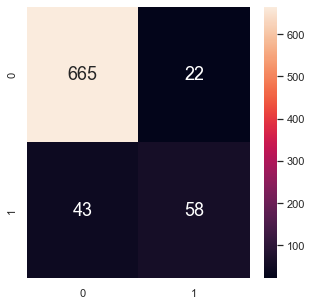

In [16]:
y_train_pred = model.predict(X_train)
evaluate(y_train_pred, y_train)

Acc:	 0.8629441624365483
TPR:	 0.4583333333333333
TNR:	 0.9190751445086706
FPR:	 0.08092485549132948
FNR:	 0.5416666666666666



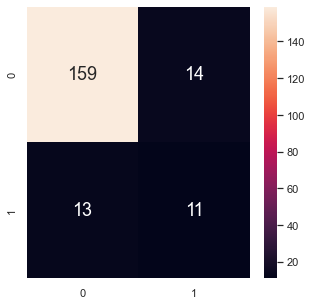

In [17]:
y_test_pred = model.predict(X_test)
evaluate(y_test_pred, y_test)

--- 
## Stochastic Gradient Descent

In [19]:
# build model class
class SGDClassifier(nn.Module):
    def __init__(self, n):
        """ Constructor function
        :param n: number of features
        """
        super(SGDClassifier, self).__init__()
        self.linear = nn.Linear(n, 1).to(device)

    def forward(self, X) -> torch.tensor:
        """ Forward Processing
        :param X: predictor tensors
        :return: predicted response tensor
        """
        y_pred = torch.sigmoid(self.linear(X))
        return y_pred

In [21]:
# # split training and testing data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# convert dataframe to tensor
X_train = torch.tensor(X_train[variables].values, dtype=torch.float32)
X_test = torch.tensor(X_test[variables].values, dtype=torch.float32)
y_train = torch.tensor(y_train['quality'].values, dtype=torch.float32)
y_test = torch.tensor(y_test['quality'].values, dtype=torch.float32)

# convert y_train and y_test from 1d tensor to 2d tensor
y_train = y_train.view([y_train.shape[0], 1])
y_test = y_test.view([y_test.shape[0], 1])


IndexError: too many indices for tensor of dimension 2

In [80]:
def do_sgd(X_train, X_test, y_train, y_test, 
        lr=1e-3, epochs=1e5,
        plotHist=True, plotConfusionMatrix=True) -> float:
    """
    Do Stochastic Gradient Descent
    :param X_train: training data for predictors
    :param X_test:testing data for predictors
    :param y_train: training data for response
    :param y_test: testing data for response
    :param plotHist: plot learning curve of loss function or not
    :param plotConfusionMatrix: plot confusion matrix in evaluation part
    :return: testing accuracy of model
    """
    # m samples, n features for training data
    m, n = X_train.shape
    # build model
    model = SGDClassifier(n).to(device)

    # construct parameters
    learning_rate = lr 
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    n_epochs = int(epochs)
    history = list()

    # training loop
    for epoch in range(n_epochs):
        # forward passing
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        # backward passing
        loss.backward()
        # update weights
        optimizer.step()
        optimizer.zero_grad()

        if plotHist:
            history.append(loss.item())

        # if epoch % int(1e5) == 0:
        #     print(f"epoch: {epoch}, loss = {loss.item():.4f}")

    # plot learning curve
    with torch.no_grad():
        if plotHist:
            dummy = np.arange(n_epochs)
            plt.plot(dummy, history)
            plt.show()

    # evaluate train result
    with torch.no_grad():
        y_train_pred = model(X_train)
        y_train_pred_cls = y_train_pred.round()
        train_accu = (y_train_pred_cls.eq(y_train)).sum() / y_train.shape[0]
        print(f"Train Accuracy: {train_accu:.4f}.")
        
        if plotConfusionMatrix:
            evaluate(y_train_pred_cls, y_train)

    # evaluate test result
    with torch.no_grad():
        y_test_pred = model(X_test)
        y_test_pred_cls = y_test_pred.round()
        test_accu = (y_test_pred_cls.eq(y_test)).sum() / y_test.shape[0]
        print(f"Test Accuracy: {test_accu:.4f}.")

        if plotConfusionMatrix:
            evaluate(y_test_pred_cls, y_test)


    return test_accu

Train Accuracy: 0.8947.
Acc:	 0.8946700507614214
TPR:	 0.37623762376237624
TNR:	 0.9708879184861717
FPR:	 0.02911208151382824
FNR:	 0.6237623762376238

Test Accuracy: 0.8934.
Acc:	 0.8934010152284264
TPR:	 0.3333333333333333
TNR:	 0.9710982658959537
FPR:	 0.028901734104046242
FNR:	 0.6666666666666666



tensor(0.8934)

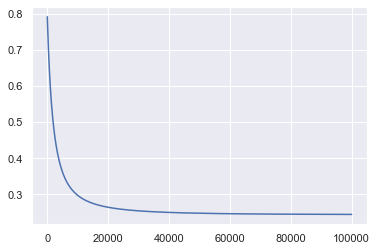

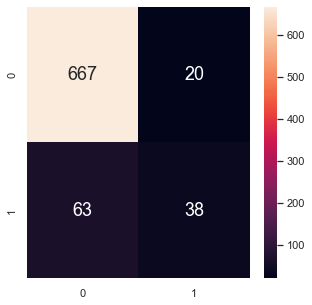

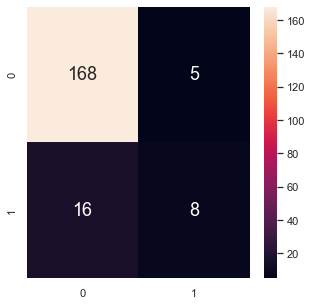

In [82]:
# estimated running time: 20 seconds
do_sgd(X_train, X_test, y_train, y_test)

--- 
## Support Vector Machine


In [83]:
from sklearn.svm import SVC

model = SVC(kernel='rbf',
        C=1,
        gamma=0.1,
        )
model.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/envs/DSAI/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, gamma=0.1)

In [84]:
# overall accuracy
print(f"For training data, accuracy={model.score(X_train, y_train)}.")
print(f"For testing data, accuracy={model.score(X_test, y_test)}.")

For training data, accuracy=0.9086294416243654.
For testing data, accuracy=0.8984771573604061.


Acc:	 0.9086294416243654
TPR:	 0.8222222222222222
TNR:	 0.9138627187079408
FPR:	 0.08613728129205922
FNR:	 0.17777777777777778



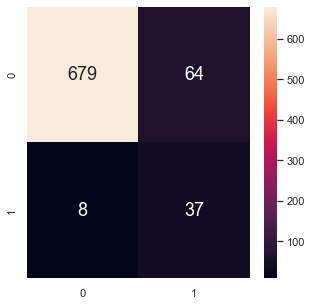

In [85]:
# Evaluation of train data
y_train_pred = model.predict(X_train)
evaluate(y_train, y_train_pred, plotConfusionMatrix=True)

Acc:	 0.9086294416243654
TPR:	 0.8222222222222222
TNR:	 0.9138627187079408
FPR:	 0.08613728129205922
FNR:	 0.17777777777777778



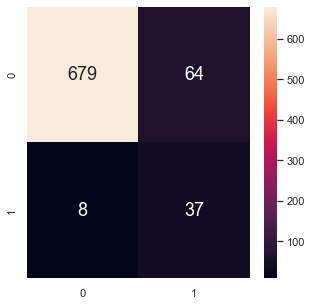

In [86]:
# Evaluation on test data
# Evaluation of train data
y_train_pred = model.predict(X_train)
evaluate(y_train, y_train_pred, plotConfusionMatrix=True)